Osnabrück University - Computer Vision (Winter Term 2018/19) - Prof. Dr.-Ing. G. Heidemann, Ulf Krumnack, Axel Schaffland

# Exercise Sheet 05: Segmentation 2

## Introduction

This week's sheet should be solved and handed in before the end of **Sunday, December 9, 2018**. If you need help (and Google and other resources were not enough), feel free to contact your groups' designated tutor or whomever of us you run into first. Please upload your results to your group's Stud.IP folder.

## Assignment 0: Math recap (Periodic functions) [0 Points]

This exercise is supposed to be very easy, does not give any points, and is voluntary. There will be a similar exercise on every sheet. It is intended to revise some basic mathematical notions that are assumed throughout this class and to allow you to check if you are comfortable with them. Usually you should have no problem to answer these questions offhand, but if you feel unsure, this is a good time to look them up again. You are always welcome to discuss questions with the tutors or in the practice session. Also, if you have a (math) topic you would like to recap, please let us know.

**a)** What are periodic functions? Can you provide a definition?

$\displaystyle \exists \, t \; \forall \, x \quad f(x) = f(x + t)$ where $t$ is the _period_ of the function

**b)** What are *amplitude*, *frequency*, *wave length*, and *phase* of a sine function? How can you change these properties?

YOUR ANSWER HERE

**c)** How are sine and cosine defined for complex arguments? In what sense does this generalize the real case?

YOUR ANSWER HERE

## Assignment 1: Edge-based segmentation  [5 Points]

### a) Edge linking

Describe in your own words the idea of edge linking. What is the goal? Why does it not necessarily yield closed
edge contours?

YOUR ANSWER HERE

### b) Zero crossings

Explain what zero crossings are. Why does the detection of zero crossings always lead to closed contours?

YOUR ANSWER HERE

### c) Zero crossings (implementation)

Provide an implementation of the zero crossing procedure described in (CV-07 slide 71). To get sensible results you should smooth the image before applying the Laplacian filter, e.g. using the Laplacian of a Gaussian (you may use buildin functions for the filterings steps).

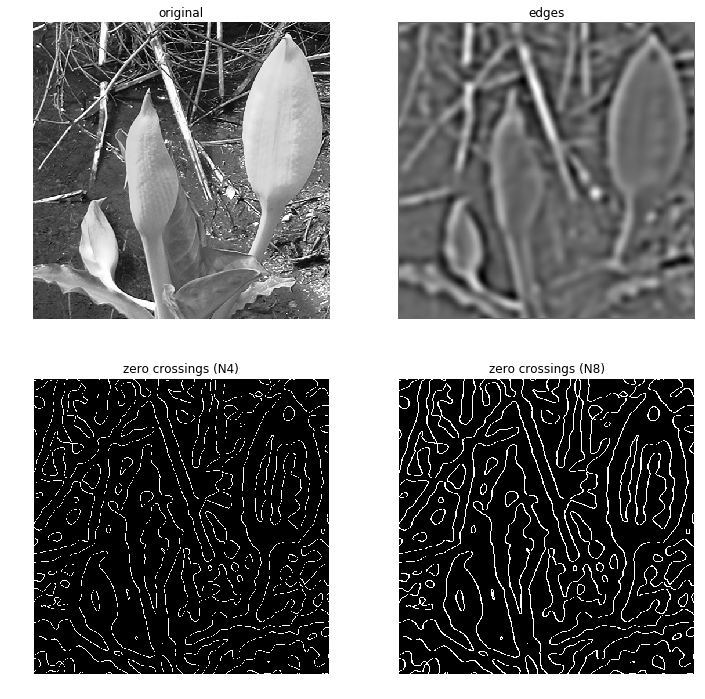

In [2]:
import numpy as np
from skimage import filters, io
import matplotlib.pyplot as plt
%matplotlib inline

img = io.imread('images/swampflower.png')

# Now compute edges and then zero crossings using the 4-neighborhood and the 8-neighborhood
smoothed_img = filters.gaussian(img, sigma=8)
edges = filters.laplace(smoothed_img)

# shifted images 
shift1 = np.pad(edges, [(1,0),(0,0)], mode="constant")[:-1,:]
shift2 = np.pad(edges, [(0,0),(1,0)], mode="constant")[:,:-1]
shift3 = np.pad(edges, [(1,0),(1,0)], mode="constant")[:-1,:-1]
shift4 = np.pad(edges, [(1,0),(0,1)], mode="constant")[:-1,1:]

# conditions for zero crossings
c1 = edges * shift1 <= 0
c2 = edges * shift2 <= 0
c3 = edges * shift3 <= 0
c4 = edges * shift4 <= 0

zero_crossings_n4 = c1 + c2
zero_crossings_n8 = c1 + c2 + c3 + c4

plt.figure(figsize=(12, 12))
plt.gray()

plt.subplot(2,2,1); plt.axis('off'); plt.imshow(img); plt.title('original')
plt.subplot(2,2,2); plt.axis('off'); plt.imshow(edges); plt.title('edges')
plt.subplot(2,2,3); plt.axis('off'); plt.imshow(zero_crossings_n4); plt.title('zero crossings (N4)')
plt.subplot(2,2,4); plt.axis('off'); plt.imshow(zero_crossings_n8); plt.title('zero crossings (N8)' )

plt.show()

## Assignment 2: Watershed transform  [5 Points]



### a) Watershed transform

Explain in your own words the idea of watershed transform. How do the two different approaches from the lecture work? Why does watershed transform always give a closed contour?



YOUR ANSWER HERE

### b) Implementation

Now implement the watershed transform using the flooding approach (CV-07 slide 76, but note, that the algorithm presented there is somewhat simplified!). Obviously, buildins for computing watershed transform are not allowed, but all other functions may be used. In this example we appply the watershed transform to a distance transformed image, so you **do not** have to take the gradient image, but can apply the watershed transform directly.

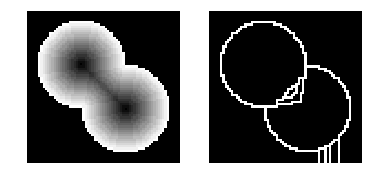

In [27]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
from itertools import product
%matplotlib inline


def watershed(img, step=1):
    """
    Perform watershed transform on a grayscale image.
    
    Args:
        img: The grayscale image.
        step (int): The rise of the waterlevel at each step. Default 1.
        
    Returns:
        A binary image containing the watersheds.
    """

    NO_LABEL = 0
    WATERSHED = 1
    new_label = 2

    # initialize labels
    label = np.zeros(img.shape, np.uint16)
    
    # img dimensions
    m,n = label.shape
    # iterate through flood heights
    for h in range(int(np.floor(img.min())), int(np.ceil(img.max())+1), step):
        # for each pixel in the flood height
        for x,y in zip(*np.where(img <= h)):
            if ~label[x,y]:
                # labels in 8-Neighbourhood
                neighbour_labels = np.unique(label[max(0, x-1):min(m, x+2), max(0, y-1):min(n, y+2)])
                # labels excluding NO_LABEL and WATERSHED
                neighbour_labels = neighbour_labels[neighbour_labels > 1]
                
                num_labels = len(neighbour_labels)
                # if single label in neighbourhood, add pixel to label
                if num_labels == 1:
                    label[x,y] = neighbour_labels[0]
                    
                # if isolated pixel, create new label
                elif(num_labels) == 0:
                    label[x,y] = new_label; new_label += 1
                    
                # if multiple labels in neighbourhood, create watershed
                else:
                    label[x,y] = WATERSHED
                    
    # set watersheds to FALSE, labels to TRUE
    label -= 1
    # binarize label image
    label = np.ma.make_mask(label)
    return np.invert(label)

img = imageio.imread('images/dist_circles.png', pilmode='L')

plt.gray()
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(img)

plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(watershed(img))
plt.show()

### c) Application: maze

You can use watershed transform to find your way through a maze. To do so, first apply a distance transform to the maze and the flood the result. The watershed will show you the way through the maze. Explain why this works.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


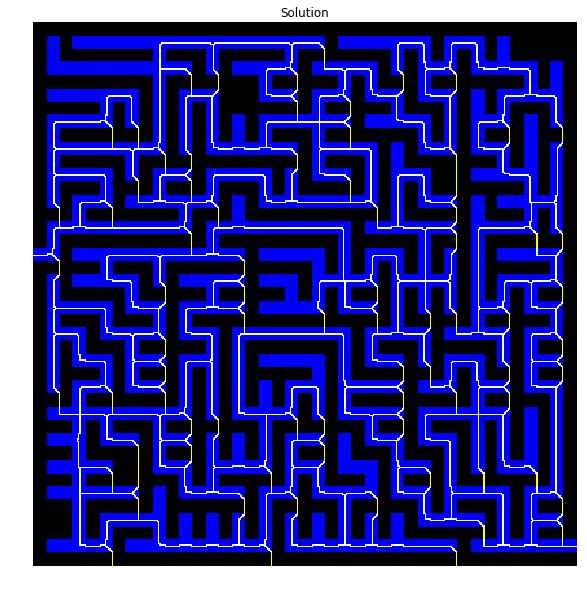

In [4]:
import imageio
import matplotlib.pyplot as plt
from scipy.ndimage.morphology import distance_transform_edt
%matplotlib inline

img = imageio.imread('images/maze2.png', pilmode = 'L') # 'maze1.png' or 'maze2.png'
result = img[:, :, np.newaxis].repeat(3, 2)
# YOUR CODE HERE
result = distance_transform_edt(result)
for i in range(2):
    result[...,i] = watershed(result[...,i])
plt.figure(figsize=(10, 10))
plt.title('Solution')
plt.axis('off')
plt.gray()
plt.imshow(result)
plt.show()

YOUR ANSWER HERE

## Assignment 3: $k$-means segmentation [5 Points]


**a)** Explain the idea of $k$-means clustering and how it can be used for segmentation.

YOUR ANSWER HERE

**b)** Implement k-means clustering for color segmentation of an RGB image (no use of `scipy.cluster.vq.kmeans` or similar functions allowed here, but you may use functions like `numpy.mean`, `scipy.spatial.distance.pdist` and similar utility functions). Stop calculation when center vectors do not change more than a predefined threshold. Avoid empty clusters by re-initializing the corresponding center vector. (Empirically) determine a good value for $k$ for clustering the image 'peppers.png'.
**Bonus** If you want you can visualize the intermediate steps of the clustering process.

First lets take a look at how our image looks in RGB colorspace. 

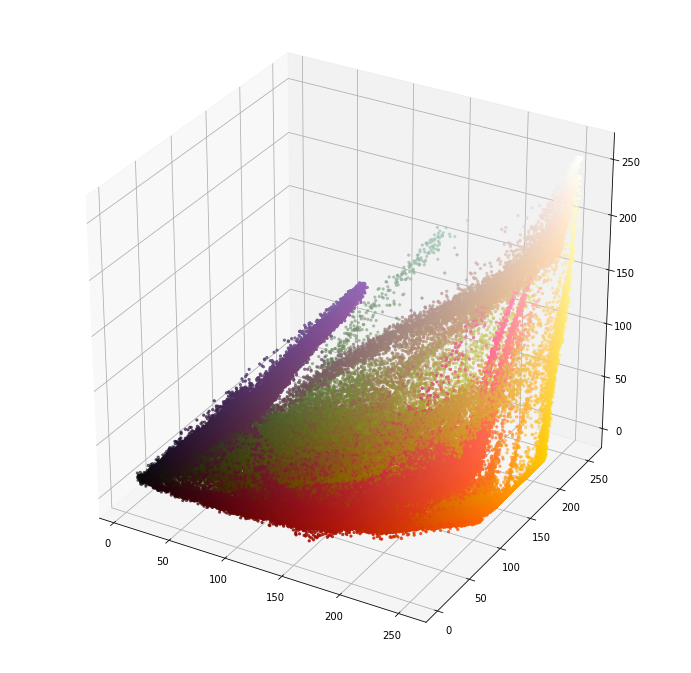

In [5]:
from mpl_toolkits.mplot3d import Axes3D
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline

img = io.imread('images/peppers.png')
vec = img.reshape((-1, img.shape[2]))
vec_scaled = vec / 255
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ret = ax.scatter(vec[:, 0], vec[:, 1], vec[:, 2], c=vec_scaled, marker='.')

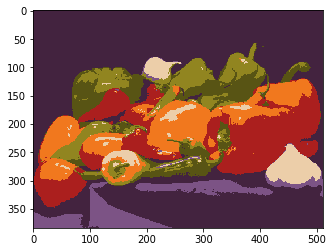

In [31]:
import numpy as np
from scipy.spatial import distance
from IPython import display
from skimage import io
import time
import matplotlib.pyplot as plt
%matplotlib inline


def kmeans_rgb(img, k, threshold=0, do_display=False):
    """
    k-means clustering in RGB space.

    Arguments:
        img (numpy.ndarray): an RGB image
        k (int): the number of clusters
        threshold (float): Maximal change for convergence criterion.
        do_display (bool): Whether or not to plot, intermediate steps.
        
    Result:
        cluster (numpy.ndarray): an array of the same size as `img`,
            containing for each pixel the cluster it belongs to
        centers (numpy.ndarray): an array
    """
    # initialize reference vectors
    center = np.array([np.random.randint(255, size=3) for _ in range(k)])
    #flatten height and width dimensions
    flat_img = np.reshape(img, (np.prod(img.shape[:-1]), 3))
    
    change = np.inf
    while change > threshold:
        change = 0
        # pointwise euclidean distance between pairs of RGB values in XA and XB
        dist = distance.cdist(XA=flat_img, XB=center)
        # cluster labels are idx at smallest distance to centroids (columns)
        cluster = np.array([np.argmin(dist[i,:]) for i in range(len(dist))])
        
        label_set = np.unique(cluster)
        for i in range(k):
            # if label has been assigned
            if i in label_set:
                # colour values from image belonging to cluster
                colours_in_label = flat_img[cluster ==  i]
                # new centroid is average of each channel
                new_center = [np.average(colours_in_label[:,channel]) for channel in range(3)]
                new_center = np.array(new_center).astype(np.int32)
            # if label has not been assigned, find better random starting centroid
            else: 
                new_center = np.random.randint(255, size=3).astype(np.int32)
            
            # update change
            change += sum(abs(center[i]-new_center))
            # update centroid list
            center[i] = new_center
    # reverse earlier flattening to original image shape
    cluster = np.reshape(cluster, img.shape[:-1])
            
    return cluster, center

img = io.imread('images/peppers.png')

cluster, centers = kmeans_rgb(img, k=7, threshold=0, do_display=True)
plt.imshow(centers[cluster])
plt.show()

**c)** Now do the same in the HSV space (remember its special topological structure). Check if you can improve the results by ignoring some of the HSV channels.

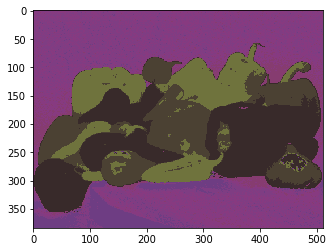

In [26]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
from skimage import color, io
from scipy.spatial import distance
import math

%matplotlib inline
# from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

img = imageio.imread('images/peppers.png', pilmode = 'RGB')

def kmeans_hsv(img, k, threshold = 0):
    """
    k-means clustering in HSV space.

    Arguments:
        img (numpy.ndarray): an HSV image
        k (int): the number of clusters
        threshold (float): 
        
    Result:
        cluster (numpy.ndarray): an array of the same size as `img`,
            containing for each pixel the cluster it belongs to
        centers (numpy.ndarray): an array
    """

    # distance.cdist requires a list of observations. clustering by hue values only
    flat_img = np.array(img[...,0]).flatten()
    # expand dimension to make 1D into 2D array
    expanded_flat_img = np.expand_dims(flat_img, axis=1)
    # random hue values
    centers = np.array([[np.random.random()] for _ in range(k)])
    
    change = np.inf
    while change > threshold:
        change = 0
        # pointwise HSV distance between hue pairs of in XA and XB
        dist = distance.cdist(XA=expanded_flat_img, 
                              XB=centers, 
                              metric=lambda x,y: min(abs(x-y), 1-abs(x-y)))
        # idx of min dist to cluster as labels
        cluster = np.array([np.argmin(dist[i,:]) for i in range(len(dist))])
        label_set = np.unique(cluster)
        for i in range(k):
            # if label is assigned
            if i in label_set:  
                # [0,1) values to 360 degrees
                cluster_values = flat_img[cluster == i]*360
                # degrees to radians [-2pi, 2pi]
                cluster_values = [math.radians(x) for x in cluster_values]
                # calc average angle
                sumcos = sumsin = 0
                for angle in cluster_values:
                    sumcos += math.cos(angle)
                    sumsin += math.sin(angle)
                # average angle in degrees
                avg_angle = math.degrees(math.atan2(sumsin, sumcos))
                # convert negative angles to positive
                if avg_angle < 0:
                    avg_angle += 360
                # degrees to [0,1)
                new_center = avg_angle / 360
            # if centroid was unsuitable and label was not assigned
            else: 
                new_center = np.random.random()
            # update change and list with cluster centers    
            change += min(abs(centers[i,0]-new_center), 1-abs(centers[i,0]-new_center))
            centers[i] = [new_center]
            
    # reverse earlier flattening to original image shape  
    cluster = np.reshape(cluster, img.shape[:-1])
    
    # add saturation and luminance to centers
    centers_hsv = np.empty([3,k], dtype=np.float32)
    # hsv averages in clusters
    centers_hsv[0] = centers.flatten()
    centers_hsv[1] = [np.average(img[cluster == label][1]) for label in range(k)]
    centers_hsv[2] = [np.average(img[cluster == label][2]) for label in range(k)]
    
    return cluster, centers_hsv.transpose()

img_hsv = color.rgb2hsv(img)
k = 7
theta = 0.01

cluster, centers_hsv = kmeans_hsv(img_hsv, k, theta)
plt.imshow(color.hsv2rgb(centers_hsv[cluster]))
plt.show()

## Assignment 4: Interactive Region Growing [5 Points]

Implement flood fill as described in (CV07 slides 123ff.).


The function `on_press` is called when a mouse button is pressed inside the canvas. From there call `floodfill`. Use the filtered hsv image `img_filtered` for your computation, and show the computed region around the seed point (the position where the mousebutton was pressed) in the original image. You may use a mask to save which pixels belong the the region (and to save which pixels you already visited). 

Hint: If you can not see the image, try restarting the kernel.

<IPython.core.display.Javascript object>


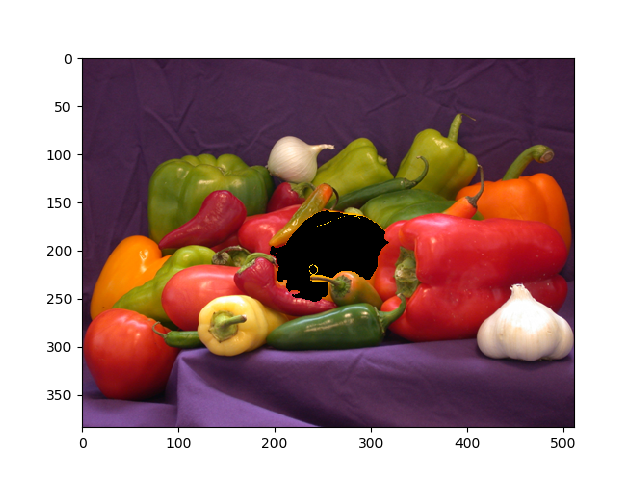

In [1]:
%matplotlib notebook
import imageio
import math
import numpy as np
from matplotlib import pyplot as plt
from skimage import color
import scipy.ndimage as ndimage
from sys import setrecursionlimit
from itertools import product

threshold = .08
FILL_COLOUR = 0 

setrecursionlimit(10000)

def floodfill(img, mask, x, y, h):
    """Recursively grows region around seed point
    
    Args: 
        img: The image in which the region is grown
        mask: Boolean ndarray in which visited pixels which belong to the
                region are saved
        x: X coordinate of the pixel. Checks if this pixels belongs to the region
        y: Y coordinate of the pixel.
        h: The color at the seed position
    """
    # height and width
    m,n,_ = img.shape
    # if distance between pixel and seed colour smaller than threshold
    if min(abs(img[x,y,0]-h), 1-abs(img[x,y,0]-h)) < threshold:
        # mark pixel as belonging to region
        mask[x,y] = True 
        eight_neighbourhood_idx = product(np.arange(max(0, x-1), min(m, x+2)), 
                                          np.arange(max(0, y-1), min(n, y+2)))
        for idx in eight_neighbourhood_idx:
            # try to fill neighbouring pixels that do not belong to region
            if mask[idx] == False:
                mask = floodfill(img, mask, *idx, h)
    return mask
          
def on_press(event):
    """Mouse button press event handler
    
    Args:
        event: The mouse event
    """
    y = math.floor(event.xdata)
    x = math.floor(event.ydata)
    # hue at mouse button press location
    h = img_filtered[x, y, 0]
    # mask indicating the region that will be filled
    mask = floodfill(img_filtered, np.zeros(img_filtered.shape[:-1]), x, y, h)
    # fill region
    img[mask == True] = FILL_COLOUR
    plt.imshow(img)
    fig.canvas.draw()
            
img = imageio.imread('images/peppers.png')
img_hsv = color.rgb2hsv(img)
img_filtered = ndimage.median_filter(img_hsv, 5)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(img)

fig.canvas.mpl_connect('button_press_event', on_press)

plt.show()
